# Dataset

### Splitting Train, Validation and Test

In [6]:
from datasets import DatasetDict, load_dataset

# Load full dataset
full_dataset = load_dataset("csv", data_files="esg_dataset.csv")["train"]

# Step 1: Split off test set (20%)
split_dataset = full_dataset.train_test_split(test_size=0.2, seed=42)
train_val = split_dataset["train"]
test = split_dataset["test"]

# Step 2: Split training set again to get validation set (10% of remaining 80%)
train_val_split = train_val.train_test_split(test_size=0.1, seed=42)
train = train_val_split["train"]
validation = train_val_split["test"]

# Wrap everything into a DatasetDict
dataset = DatasetDict({
    "train": train,
    "validation": validation,
    "test": test
})

### Data is in Apache Arrow Format

Apache Arrow format does not load the data into memory and speeds up operations like batching, filtering and .map() functions.

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'preprocessed_content', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score'],
        num_rows: 622
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'preprocessed_content', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score'],
        num_rows: 70
    })
    test: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'preprocessed_content', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score'],
        num_rows: 174
    })
})

### View in Pandas

You can convert it back into panda for data visualisation

In [12]:
import pandas as pd

# Convert the train split to pandas
df = dataset["train"].to_pandas()

df.head()

,Unnamed: 0,filename,ticker,year,preprocessed_content,ner_entities,e_score,s_score,g_score,total_score
0,595,NYSE_LMT_2022.pdf,LMT,2022,propel principle report proud present sustaina...,"['martin', 'martin sustainability', 'the calen...",5.27,15.93,7.34,28.53
1,347,NYSE_AXP_2019.pdf,AXP,2019,powerful backing american express environmenta...,"['american', 'american', 'year', 'american', '...",0.07,13.13,10.19,23.25
2,560,NYSE_IVZ_2018.pdf,IVZ,2018,corporate social responsibility report commitm...,"['invesco', 'un', 'more than four tons', 'dail...",1.47,14.46,10.93,26.29
3,400,NYSE_CMA_2019.pdf,CMA,2019,statement document historical fact look statem...,"['one', 'the securities and exchange commissio...",2.10,11.32,12.22,25.91
4,320,NYSE_AMT_2020.pdf,AMT,2020,report sustainability report table content ame...,"['american', 'american', 'american', 'first', ...",5.81,6.68,5.60,18.09


### Sample view

The report has already been preprocessed for training

In [16]:
sample = dataset["train"].shuffle(seed=42).select(range(100))
# Peek at the first few examples
sample[:1]

{'Unnamed: 0': [410],
 'filename': ['NYSE_CMS_2020.pdf'],
 'ticker': ['CMS'],
 'year': [2020],
 'preprocessed_content': ['environmental social governance sustainability report consistent template environmental social governance esg sustainability report section qualitative information introduction energy primary subsidiary consumer energy integrate sustainable principle company commitment triple line people planet prosperity foundation large utility consideration environmental social governance esg issue embed strategy business planning enterprise risk management process commitment align purpose world class performance deliver hometown service triple line balance interest stakeholder include worker customer supplier regulator resident investment community energy participate voluntary industry initiative coordinate provide public customer shareholder uniform consistent esg relate metric report supplement exist disclosure issue include sustainability report sustainability website find st

### Rename the columns

In [18]:
dataset = dataset.rename_column("preprocessed_content", "report")

### Compute report length

In [19]:
def compute_report_length(batch):
    return {"report_length": [len(text.split()) for text in batch["report"]]}

dataset = dataset.map(compute_report_length, batched=True)

Map:   0%|          | 0/622 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/174 [00:00<?, ? examples/s]

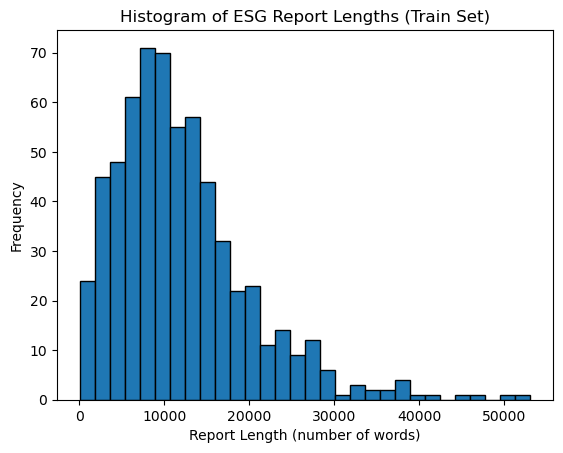

In [23]:
import matplotlib.pyplot as plt

# Extract report lengths as a list
lengths = dataset["train"]["report_length"]

plt.hist(lengths, bins=30, edgecolor='black')
plt.xlabel('Report Length (number of words)')
plt.ylabel('Frequency')
plt.title('Histogram of ESG Report Lengths (Train Set)')
plt.show()

The report length is extremely long. A good model to train on will be "allenai/longformer-base-4096" which has 4096-token limit.

### Save the dataset

In [44]:
dataset.save_to_disk("esg_reports")

Saving the dataset (0/1 shards):   0%|          | 0/622 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/70 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/174 [00:00<?, ? examples/s]

We can load the dataset again using load_from_disk

In [4]:
from datasets import load_from_disk

dataset= load_from_disk("esg_reports")
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'report', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score', 'report_length'],
        num_rows: 622
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'report', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score', 'report_length'],
        num_rows: 70
    })
    test: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'report', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score', 'report_length'],
        num_rows: 174
    })
})

# Tokenizer

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")

### Tokenize

Since the max length is 4096 tokens, we set return_overflowing_tokens=True so that long reports are returned in chunks of 4096 tokens.  
With "overflow_to_sample_mapping", we can repeat values in other columns for chunks belonging to the same report

Note: I have set max_length=1024 as my GPU Vram(4GB) is out of memory, set this to lower or higher depending on how much vram you have.

In [6]:
def tokenize_and_split(examples):
    result = tokenizer(
        examples["report"],
        truncation=True,
        max_length=1024,
        return_overflowing_tokens=True,
        stride=256
    )
    
    sample_map = result.pop("overflow_to_sample_mapping")

    # Repeat all original fields to match chunked outputs
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]

    return result

In [7]:
tokenized_dataset = dataset.map(
    tokenize_and_split,
    batched=True
)

Map:   0%|          | 0/622 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/174 [00:00<?, ? examples/s]

In [9]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'report', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score', 'report_length', 'input_ids', 'attention_mask'],
        num_rows: 10721
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'report', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score', 'report_length', 'input_ids', 'attention_mask'],
        num_rows: 1187
    })
    test: Dataset({
        features: ['Unnamed: 0', 'filename', 'ticker', 'year', 'report', 'ner_entities', 'e_score', 's_score', 'g_score', 'total_score', 'report_length', 'input_ids', 'attention_mask'],
        num_rows: 3006
    })
})

In [10]:
cols_to_remove = [col for col in tokenized_dataset["train"].column_names if col not in ["e_score", "s_score", "g_score", "total_score", "input_ids", "attention_mask"]]

tokenized_dataset = tokenized_dataset.remove_columns(cols_to_remove)
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['e_score', 's_score', 'g_score', 'total_score', 'input_ids', 'attention_mask'],
        num_rows: 10721
    })
    validation: Dataset({
        features: ['e_score', 's_score', 'g_score', 'total_score', 'input_ids', 'attention_mask'],
        num_rows: 1187
    })
    test: Dataset({
        features: ['e_score', 's_score', 'g_score', 'total_score', 'input_ids', 'attention_mask'],
        num_rows: 3006
    })
})

In [11]:
tokenized_dataset.save_to_disk("esg_tokenized")

Saving the dataset (0/1 shards):   0%|          | 0/10721 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1187 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3006 [00:00<?, ? examples/s]